In [14]:
import numpy as np
import math
import torch
from torch import nn
import torch.nn.functional as F

import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt


print(torch.__version__) #1.4.0


1.4.0


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Predictor network #

In [24]:
def get_mlp(input_dim, layerwidth, nblayers, activation):
    param_count = (input_dim+1)*layerwidth+(nblayers-1) * \
        (layerwidth**2+layerwidth)+layerwidth+1

    def mlp(x, theta, input_dim=input_dim, layerwidth=layerwidth, nb_layers=nblayers, activation=activation):
        """
        Feedforward neural network used as the predictor model

        Parameters:
            x (Tensor): Input of the network of size NbExemples X NbDimensions   
            theta (Tensor):  M set of parameters of the network NbModels X NbParam
            input_dim (Int): dimensions of NN's inputs (=NbDimensions)
            layerwidth (Int): Number of hidden units per layer 
            nb_layers (Int): Number of layers
            activation (Module/Function): activation function of the neural network

        Returns:
            Predictions (Tensor) with dimensions NbModels X NbExemples X NbDimensions

        Example:

        input_dim=11
        nblayers = 2
        activation=nn.Tanh()
        layerwidth = 20
        param_count = (input_dim+1)*layerwidth+(nblayers-1)*(layerwidth**2+layerwidth)+layerwidth+1

        x=torch.rand(3,input_dim)
        theta=torch.rand(5,param_count)
        mlp(x,theta,input_dim=input_dim,layerwidth=layerwidth,nb_layers=nblayers,activation=activation)

        """

        nb_theta = theta.shape[0]
        nb_x = x.shape[0]
        split_sizes = [input_dim*layerwidth]+[layerwidth] + \
            [layerwidth**2, layerwidth]*(nb_layers-1)+[layerwidth, 1]
        theta = theta.split(split_sizes, dim=1)
        input_x = x.view(nb_x, input_dim, 1)
        m = torch.matmul(theta[0].view(
            nb_theta, 1, layerwidth, input_dim), input_x)
        m = m.add(theta[1].reshape(nb_theta, 1, layerwidth, 1))
        m = activation(m)
        for i in range(nb_layers-1):
            m = torch.matmul(
                theta[2*i+2].view(-1, 1, layerwidth, layerwidth), m)
            m = m.add(theta[2*i+3].reshape(-1, 1, layerwidth, 1))
            m = activation(m)
        m = torch.matmul(
            theta[2*(nb_layers-1)+2].view(nb_theta, 1, 1, layerwidth), m)
        m = m.add(theta[2*(nb_layers-1)+3].reshape(nb_theta, 1, 1, 1))
        return m.squeeze(-1)
    return param_count, mlp




In [51]:
# Toy setting example #

input_dim=1
layerwidth=50
nblayers=1
activation=nn.Tanh()

param_count, predictor = get_mlp(1,layerwidth, nblayers, activation)

nb_samples_functions=1000
#the prior we for our toy examples
t= .5*torch.randn(size=(nb_samples_functions,param_count), device=device) 

s= .5*torch.randn(size=(nb_samples_functions,param_count), device=device) 

n_samples_input=20
#sampling inputs uniformly in [-2,2]:
X=torch.Tensor(20).uniform_(-2.,2).to(device)

#computing projections or functions evaluations f^X_\theta:
f_X=predictor(X,theta)

def projection(s,t,m):
    X=torch.Tensor(m).uniform_(-2.,2).to(device)
    s_X=predictor(X,t).squeeze()
    t_X=predictor(X,s).squeeze()
    return s_X, t_X

s_X, t_X =projection(s,t,20)
s_X.shape

torch.Size([1000, 20])

# Metrics on vectorial distributions #

In [34]:
def KL(theta0,theta1,k=1,device='cpu', p=2):
        """
        Parameters:
            theta0 (Tensor): Samples, P X NbDimensions   
            theta1 (Tensor): Samples, R X NbDimensions   
            k (Int): positive ordinal number 

        Returns:
            (Float) k-Nearest Neighbour Estimation of the KL from theta0 to theta1  

        Kullback-Leibler Divergence Estimation of Continuous Distributions Fernando Pérez-Cruz
        """
        
        n0=theta0.shape[0]
        n1=theta1.shape[0]
        dim0=theta0.shape[1]
        dim1=theta1.shape[1]
        assert dim0 == dim1
        
        D0=torch.cdist(theta0,theta0, p=p)
        D1=torch.cdist(theta0,theta1,p=p)

        a0 = torch.topk(D0, k=k+1, dim=1, largest=False, sorted=True)[0][:,k]#.clamp(torch.finfo().eps,float('inf')).to(device)
        a1 = torch.topk(D1, k=k, dim=1, largest=False, sorted=True)[0][:,k-1]#.clamp(torch.finfo().eps,float('inf')).to(device)
        
        assert a0.shape == a1.shape
        
        d=torch.as_tensor(float(dim0),device=device)
        N0=torch.as_tensor(float(n0),device=device)
        N1=torch.as_tensor(float(n1),device=device)
        
        Mnn=(torch.log(a1)-torch.log(a0)).mean()
        return dim0*Mnn + N1.log()-(N0-1).log()

# Sliced Wassertstein
    
def sphere(L,dim):
    theta=torch.randn(size=(L,dim))
    directions=F.normalize(theta, p=2, dim=1)
    return  directions

def proj1d(S,u):
    """
    inputs:
        S: Tensor M x D
        u: Tensor K x D
        
    returns:
        dot: Tensor Kx M
    
    """
    assert S.shape[1] == u.shape[1]
    dim=S.shape[1]
    S_=S.view(S.shape[0],dim,1)
    u_=u.view(u.shape[0],1,1,dim)
    dot=torch.matmul(u_, S_).squeeze()
    return dot

def sw(S0,S1, device, L=1000):
    assert S0.shape[1] == S1.shape[1]
    dim=S0.shape[1]
    u=sphere(L,dim).to(device)
    S0_1d=proj1d(S0,u)
    S1_1d=proj1d(S1,u)
    W=[st.wasserstein_distance(S0_1d[i,:].cpu(), S1_1d[i,:].cpu()) for i in range(L)]
    return np.mean(W), np.std(W)/L

# Metrics on functional distributions #

In [58]:
n_samples_input=50


def FunSW(t,s,projection, n=50, n_samples_inputs=n_samples_input, L=100):
    assert t.shape == s.shape
    W=torch.Tensor(n)
    for i in range(n):
        t_, s_= projection(t, s, n_samples_inputs)
        # I added 1/sqrt(n_samples_input) the scaling factor we discussed :-)
        W[i]=1/torch.tensor(float(n_samples_input)).sqrt()*sw(s_, t_,device, L=L)[0] 
    return W.mean(), W.std()

def FunKL(t,s,projection,k=1,n=100, m=n_samples_input):
    assert t.shape == s.shape
    K=torch.Tensor(n)
    for i in range(n):
        t_, s_= projection(t, s, m)
        K[i]=KL(t_, s_, k=k,device=device)
    return K.mean(), K.std()

def SFunKL(t,s,projection,k=1,n=100, m=n_samples_input):
    K=FunKL(t,s,projection)+FunKL(s,t,projection)
    return K

# Testing metrics for vectors #

$$ \text{KL}(Q,P)=\int \log(\frac{dQ}{dP})dQ= -H(Q) - \int \log(p) dQ $$

In [22]:
s=torch.randn(1000,100)
t=torch.randn(1000,100)+10*torch.ones(1000,100)
print('SW(s,t):'+str(sw(s.to(device),t.to(device),device)))
print('KL(s,t):'+str(KL(s,t,device=device)))
print('KL(t,s):'+str(KL(t,s,device=device)))


SW(s,t):(8.033769123433734, 0.006214062104867524)
KL(s,t):tensor(215.4801)
KL(t,s):tensor(215.8794)


In [23]:
s=10*torch.randn(1000,100) #large entropy H(s)
t=torch.randn(1000,100)+10*torch.ones(1000,100) #small entropy H(t)
print('SW(s,t):'+str(sw(s.to(device),t.to(device),device)))
print('KL(s,t):'+str(KL(s,t,device=device))) #-H(s) - ...
print('KL(t,s):'+str(KL(t,s,device=device))) #-H(t) - ...

SW(s,t):(10.940051001408364, 0.004523609187823627)
KL(s,t):tensor(19.4278)
KL(t,s):tensor(229.6066)


# Testing metrics for vectors #

In [53]:
nb_samples_functions=1000
#the prior we for our toy examples
t= .5*torch.randn(size=(nb_samples_functions,param_count), device=device) 
s= .5*torch.randn(size=(nb_samples_functions,param_count), device=device) 

FunKL(s,t,projection, n=200)


(tensor(0.6062), tensor(0.0890))

In [60]:
FunKL(t,s,projection, n=200)

(tensor(-0.2763), tensor(0.2249))

In [61]:
FunSW(s,t,projection, n=100, L=100)

(tensor(0.0184), tensor(0.0014))

In [62]:
nb_samples_functions=1000
#the prior we for our toy examples
t= .5*torch.randn(size=(nb_samples_functions,param_count), device=device) 
s= 1.*torch.randn(size=(nb_samples_functions,param_count), device=device) 

FunKL(s,t,projection, n=200)


(tensor(42.4242), tensor(0.5656))

In [63]:
FunKL(t,s,projection, n=200)

(tensor(27.7950), tensor(0.5044))

In [64]:
FunSW(s,t,projection, n=100, L=100)

(tensor(0.3329), tensor(0.0150))

# Visualizing

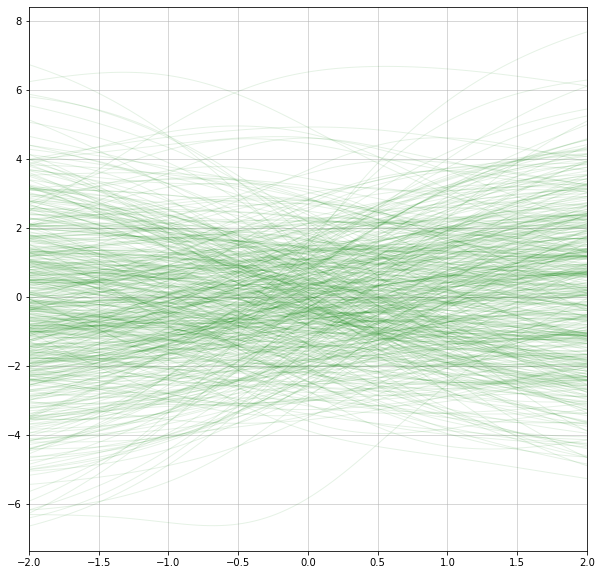

In [74]:
def makePlot(theta, device):
        nb_samples_plot=theta.shape[0]
        x_lin = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
        fig, ax = plt.subplots()
        fig.set_size_inches(10, 10)
        plt.xlim(-2, 2) 
        #plt.ylim(-5, 5)
        plt.grid(True, which='major', linewidth=0.5)
        theta=theta.detach().to(device)
        for i in range(theta.shape[0]):
            y_pred = predictor(x_lin, theta[i,:].unsqueeze(0))
            plt.plot(x_lin.detach().cpu().numpy(), y_pred.squeeze(0).detach().cpu().numpy(), alpha=0.1, linewidth=1.0, color='green',zorder=3)

t=0.5*torch.randn(500, param_count).to(device)

%matplotlib inline
makePlot(t,device)